<a href="https://colab.research.google.com/github/guanyuq03/ECON5200-Applied-Data-Analytics-in-Economics/blob/main/Class%204/%5BLab_4%5D_Descriptive_Statistics_%26_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64


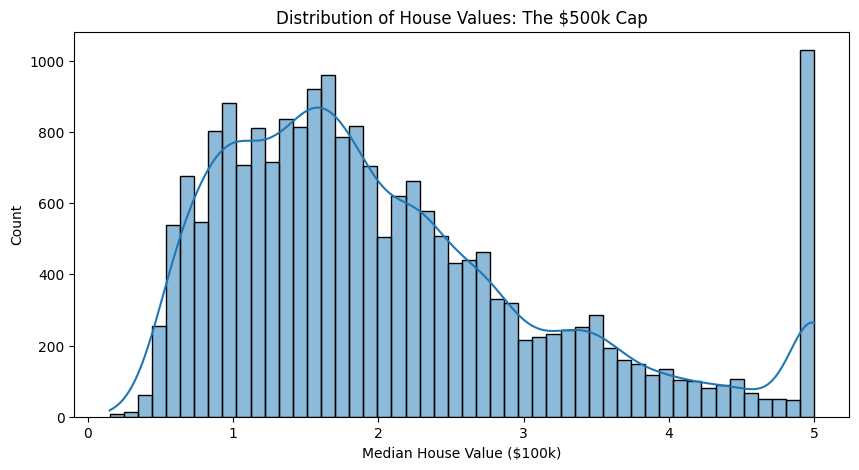

In [10]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Ingest Data
data = fetch_california_housing(as_frame=True)
df = data.frame

# Inspect the Ceiling Effect
print(df['MedHouseVal'].describe())

plt.figure(figsize=(10, 5))
sns.histplot(df['MedHouseVal'], bins=50, kde=True)
plt.title("Distribution of House Values: The $500k Cap")
plt.xlabel("Median House Value ($100k)")
plt.show()

In [11]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [12]:
def flag_outliers_iqr(df, column):
    # Calculate Quartiles
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the Tukey Fence
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Return Boolean Mask
    return (df[column] < lower_bound) | (df[column] > upper_bound)

# Apply to Median Income
df['outlier_iqr'] = flag_outliers_iqr(df, 'MedInc')

print(f"Manual Outliers Detected: {df['outlier_iqr'].sum()}")
print("These are primarily the 'Wealthy' districts.")

Manual Outliers Detected: 681
These are primarily the 'Wealthy' districts.


In [13]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,outlier_iqr
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,True
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,True
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,False
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,False
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,False
...,...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781,False
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771,False
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923,False
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847,False


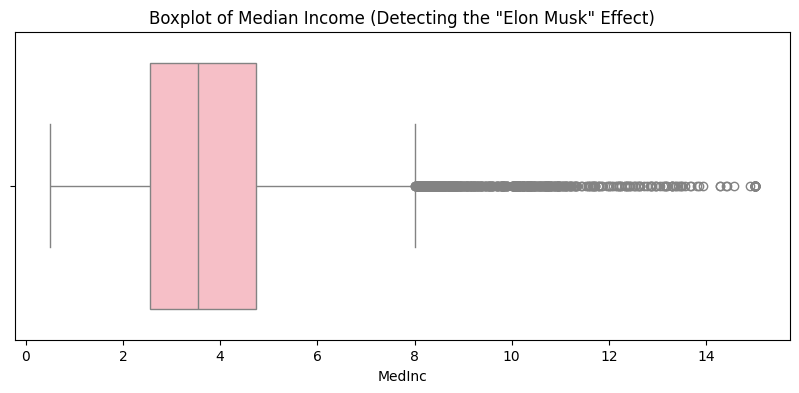

In [14]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['MedInc'], color='lightpink')
plt.title('Boxplot of Median Income (Detecting the "Elon Musk" Effect)')
plt.show()

In [15]:
# Initialize the model
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# Features to analyze (income, house age, average rooms)
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population']

# Fit and Predict (-1 = Outlier, 1 = Normal)
preds = iso_forest.fit_predict(df[features])

# Map to boolean (True if outlier)
df['outlier_iso'] = preds == -1

print(f"Algorithmic Outliers Detected: {df['outlier_iso'].sum()}")

Algorithmic Outliers Detected: 1032


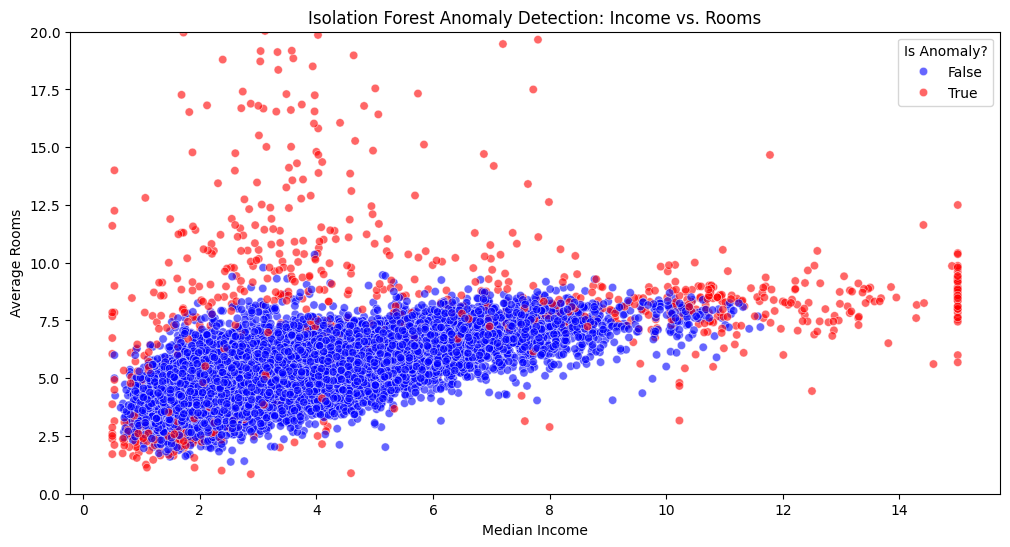

In [16]:
plt.figure(figsize=(12, 6))

# Plot points flagged by Isolation Forest
sns.scatterplot(
    data=df,
    x='MedInc',
    y='AveRooms',
    hue='outlier_iso',
    palette={True: 'red', False: 'blue'},
    alpha=0.6
)

plt.title("Isolation Forest Anomaly Detection: Income vs. Rooms")
plt.xlabel("Median Income")
plt.ylabel("Average Rooms")
# Zoom in to ignore extreme errors
plt.ylim(0, 20)
plt.legend(title='Is Anomaly?')
plt.show()


=== Comparative Forensics Summary (Mean/Median + Volatility) ===
     Group       Metric   Mean  Median  Std_Dev    MAD
0   Normal       MedInc  3.770   3.516    1.641  1.032
1   Normal  MedHouseVal  2.037   1.789    1.114  0.674
2  Outlier       MedInc  5.791   4.257    4.145  2.492
3  Outlier  MedHouseVal  2.668   2.057    1.635  1.103

=== Inequality Wedge (Outliers) ===
        Metric   Mean  Median  Inequality_Wedge
2       MedInc  5.791   4.257             1.534
3  MedHouseVal  2.668   2.057             0.611


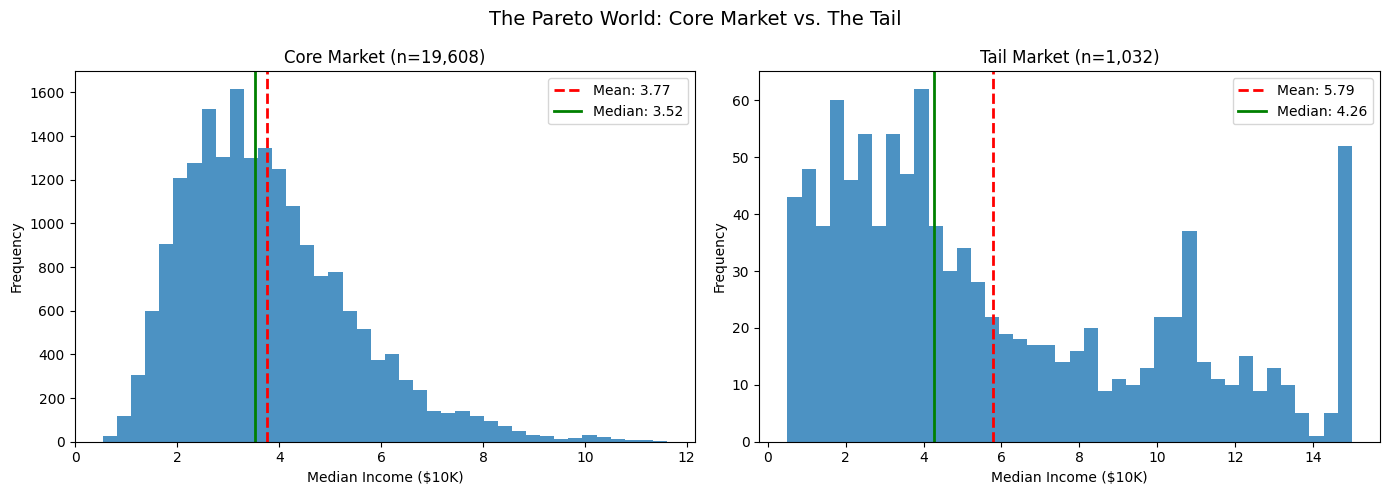

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Split data
# -----------------------------
df_normal = df[df["outlier_iso"] == False].copy()
df_outlier = df[df["outlier_iso"] == True].copy()

metrics = ["MedInc", "MedHouseVal"]

# -----------------------------
# 2) Mean & Median for both groups
# -----------------------------
summary_stats = []
for group_name, subset in [("Normal", df_normal), ("Outlier", df_outlier)]:
    for col in metrics:
        summary_stats.append({
            "Group": group_name,
            "Metric": col,
            "Mean": subset[col].mean(),
            "Median": subset[col].median()
        })

summary_df = pd.DataFrame(summary_stats)

# -----------------------------
# 3) Std Dev vs MAD (volatility)
# -----------------------------
def mad(series: pd.Series) -> float:
    s = series.dropna().to_numpy()
    med = np.median(s)
    return np.median(np.abs(s - med))

volatility_stats = []
for group_name, subset in [("Normal", df_normal), ("Outlier", df_outlier)]:
    for col in metrics:
        volatility_stats.append({
            "Group": group_name,
            "Metric": col,
            "Std_Dev": subset[col].std(),
            "MAD": mad(subset[col])
        })

volatility_df = pd.DataFrame(volatility_stats)

# Optional: merge summary + volatility into one forensic table (nice to print)
report_df = summary_df.merge(volatility_df, on=["Group", "Metric"], how="left")

print("\n=== Comparative Forensics Summary (Mean/Median + Volatility) ===")
print(report_df.round(3))

# -----------------------------
# 4) Inequality Wedge (Outliers) = Mean - Median
# -----------------------------
inequality_wedge = summary_df[summary_df["Group"] == "Outlier"].copy()
inequality_wedge["Inequality_Wedge"] = inequality_wedge["Mean"] - inequality_wedge["Median"]

print("\n=== Inequality Wedge (Outliers) ===")
print(inequality_wedge[["Metric", "Mean", "Median", "Inequality_Wedge"]].round(3))

# -----------------------------
# 5) Visualization: histograms + Mean/Median lines
# -----------------------------
plt.figure(figsize=(14, 5))

# Left: Normal distribution
ax1 = plt.subplot(1, 2, 1)
ax1.hist(df_normal["MedInc"].dropna(), bins=40, alpha=0.8)

mean_normal = df_normal["MedInc"].mean()
median_normal = df_normal["MedInc"].median()

ax1.axvline(mean_normal, linestyle="--", color = "red", linewidth=2, label=f"Mean: {mean_normal:.2f}")
ax1.axvline(median_normal, linestyle="-", color = "green", linewidth=2, label=f"Median: {median_normal:.2f}")

ax1.set_title(f"Core Market (n={len(df_normal):,})")
ax1.set_xlabel("Median Income ($10K)")
ax1.set_ylabel("Frequency")
ax1.legend()

# Right: Outlier distribution
ax2 = plt.subplot(1, 2, 2)
ax2.hist(df_outlier["MedInc"].dropna(), bins=40, alpha=0.8)

mean_outlier = df_outlier["MedInc"].mean()
median_outlier = df_outlier["MedInc"].median()

ax2.axvline(mean_outlier, linestyle="--", color = "red",linewidth=2, label=f"Mean: {mean_outlier:.2f}")
ax2.axvline(median_outlier, linestyle="-", color = "green", linewidth=2,label=f"Median: {median_outlier:.2f}")

ax2.set_title(f"Tail Market (n={len(df_outlier):,})")
ax2.set_xlabel("Median Income ($10K)")
ax2.set_ylabel("Frequency")
ax2.legend()

plt.suptitle("The Pareto World: Core Market vs. The Tail", fontsize=14)
plt.tight_layout()
plt.show()